In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_z
from numba import njit

**ODE for y**:
\begin{align*}
0 = \max_{\tilde{e}} \min_h \min_{\pi_i^c, \sum_{i=1}^n \pi_i=1} &  -\delta \phi(y) + \delta \eta \log \tilde{e} \\
&+ \frac{d\phi(y)}{dy}\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i + \sigma_y \cdot h) + \frac{1}{2} \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})^2\\
& + (\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]\tilde{e}(\sum_{i=1}^n \pi_i^c\theta_i + \sigma_y \cdot h)\\
& +\frac{\xi_{1,m}}{2}h^\prime h + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)
\end{align*}


The FOC of $h$ gives:
$$
h^* = -\frac{\left(\frac{d\phi(y)}{dy} + (\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]\right)\tilde{e}\sigma_y}{\xi_{1,m}}
$$


Substitute $h$ with $h^*$ in the ODE:

\begin{align*}
0 = \max_{\tilde{e}} & -\delta \phi(y) + \delta \eta \log \tilde{e} \\
& + G(y)\tilde{e} \pi_i^c\theta_i + \frac{1}{2} \left(\frac{d^2 \phi(y)}{(d y)^2}-\frac{G^2(y)}{\xi_m}\right)|\sigma_y|^2(\tilde{e})^2\\
& + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
\end{align*}

where $G(y):=\frac{d\phi}{dy} + (\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]$

The FOC of $\tilde{e}$ gives:
$$
\tilde{e}^* = \frac{-\theta G(y) + \sqrt{\theta^2G^2(y)-4\delta \eta |\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_m}\right)}}{2|\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_m}\right)}
$$

In [2]:
# Model parameters
η = .032
δ = .01
θ = 1.86/1000.
σ_y = 1.2*1.86/1000.

ξ_m = 1/4000

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = .0197*2 # high damage
y_bar = 2.

n_y = 100
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

model_paras = (η, δ, θ, σ_y, ξ_m, γ_1, γ_2, γ_2p, y_bar) 
ϕ, e_tilde = ode_y(y_grid, model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=5_000, print_all=True)

Iteration 1: LHS Error: 0.0012591532188095992; RHS Error 0.0013541926710562498
Iteration 2: LHS Error: 0.0010920869218999248; RHS Error 0.0011380268759322526
Iteration 3: LHS Error: 0.0010177295803590696; RHS Error 0.0010463093618533913
Iteration 4: LHS Error: 0.0009669185503096219; RHS Error 0.0009873709666002339
Iteration 5: LHS Error: 0.000927720761552204; RHS Error 0.000943672372467334
Iteration 6: LHS Error: 0.0008955516881730937; RHS Error 0.0009086257371724599
Iteration 7: LHS Error: 0.0008681025582693257; RHS Error 0.000879176140452739
Iteration 8: LHS Error: 0.0008440530800186141; RHS Error 0.0008536537138874778
Iteration 9: LHS Error: 0.0008221377354656872; RHS Error 0.0008310493152726356
Iteration 10: LHS Error: 0.0008028268024678608; RHS Error 0.0008105796307359237
Iteration 11: LHS Error: 0.0007850963916668698; RHS Error 0.0007920200898528366
Iteration 12: LHS Error: 0.0007686961273521836; RHS Error 0.0007749691687823613
Iteration 13: LHS Error: 0.0007534211792245647; RHS 

Iteration 323: LHS Error: 7.338583322344383e-05; RHS Error 7.354632068619815e-05
Iteration 324: LHS Error: 7.302096659903001e-05; RHS Error 7.318124425049327e-05
Iteration 325: LHS Error: 7.265791230720575e-05; RHS Error 7.28179818173261e-05
Iteration 326: LHS Error: 7.229666136143731e-05; RHS Error 7.245652438231268e-05
Iteration 327: LHS Error: 7.193720481925292e-05; RHS Error 7.2096862985689e-05
Iteration 328: LHS Error: 7.157953378222892e-05; RHS Error 7.173898871208997e-05
Iteration 329: LHS Error: 7.122363939562892e-05; RHS Error 7.138289269033196e-05
Iteration 330: LHS Error: 7.086951284830667e-05; RHS Error 7.102856609319619e-05
Iteration 331: LHS Error: 7.051714537244236e-05; RHS Error 7.067600013721162e-05
Iteration 332: LHS Error: 7.016652824340386e-05; RHS Error 7.032518608243959e-05
Iteration 333: LHS Error: 6.981765277944141e-05; RHS Error 6.99761152322618e-05
Iteration 334: LHS Error: 6.947051034152107e-05; RHS Error 6.96287789331649e-05
Iteration 335: LHS Error: 6.91250

Iteration 660: LHS Error: 1.36755066986044e-05; RHS Error 1.3812395925282884e-05
Iteration 661: LHS Error: 1.3607492514819408e-05; RHS Error 1.374435994422286e-05
Iteration 662: LHS Error: 1.3539816381899494e-05; RHS Error 1.3676662127744136e-05
Iteration 663: LHS Error: 1.3472476620882134e-05; RHS Error 1.36093007961865e-05
Iteration 664: LHS Error: 1.3405471561103721e-05; RHS Error 1.3542274278227368e-05
Iteration 665: LHS Error: 1.3338799540199564e-05; RHS Error 1.3475580910837976e-05
Iteration 666: LHS Error: 1.3272458904062256e-05; RHS Error 1.3409219039243808e-05
Iteration 667: LHS Error: 1.3206448006744531e-05; RHS Error 1.3343187016883504e-05
Iteration 668: LHS Error: 1.3140765210514771e-05; RHS Error 1.3277483205367661e-05
Iteration 669: LHS Error: 1.3075408885843132e-05; RHS Error 1.321210597443796e-05
Iteration 670: LHS Error: 1.3010377411082352e-05; RHS Error 1.3147053701927916e-05
Iteration 671: LHS Error: 1.2945669172773067e-05; RHS Error 1.3082324773722761e-05
Iteration 

Iteration 998: LHS Error: 2.5353547237483287e-06; RHS Error 6.203616355470739e-06
Iteration 999: LHS Error: 2.522743977162456e-06; RHS Error 6.196548603768295e-06
Iteration 1000: LHS Error: 2.510195918986602e-06; RHS Error 6.189510414394972e-06
Iteration 1001: LHS Error: 2.49771023778933e-06; RHS Error 6.182501675810353e-06
Iteration 1002: LHS Error: 2.4852866237073945e-06; RHS Error 6.175522276796871e-06
Iteration 1003: LHS Error: 2.47292476837635e-06; RHS Error 6.168572106461136e-06
Iteration 1004: LHS Error: 2.4606243650138193e-06; RHS Error 6.161651054232631e-06
Iteration 1005: LHS Error: 2.4483851083362262e-06; RHS Error 6.1547590098644765e-06
Iteration 1006: LHS Error: 2.4362066945171623e-06; RHS Error 6.147895863432937e-06
Iteration 1007: LHS Error: 2.4240888213539202e-06; RHS Error 6.1410615053375875e-06
Iteration 1008: LHS Error: 2.4120311880454492e-06; RHS Error 6.13425582630085e-06
Iteration 1009: LHS Error: 2.400033495331133e-06; RHS Error 6.127478717367997e-06
Iteration 10

Iteration 1337: LHS Error: 4.6768616222825354e-07; RHS Error 4.9439361122902874e-06
Iteration 1338: LHS Error: 4.653596346049227e-07; RHS Error 4.942347286608997e-06
Iteration 1339: LHS Error: 4.630446737291516e-07; RHS Error 4.940765684914117e-06
Iteration 1340: LHS Error: 4.6074122220240987e-07; RHS Error 4.939191275401552e-06
Iteration 1341: LHS Error: 4.5844922275106725e-07; RHS Error 4.937624026399751e-06
Iteration 1342: LHS Error: 4.5616861854558266e-07; RHS Error 4.936063906369354e-06
Iteration 1343: LHS Error: 4.5389935293682626e-07; RHS Error 4.9345108839028945e-06
Iteration 1344: LHS Error: 4.51641369553224e-07; RHS Error 4.932964927723823e-06
Iteration 1345: LHS Error: 4.493946124256576e-07; RHS Error 4.931426006686589e-06
Iteration 1346: LHS Error: 4.471590256821534e-07; RHS Error 4.929894089775774e-06
Iteration 1347: LHS Error: 4.449346505952523e-07; RHS Error 4.928369146105574e-06
Iteration 1348: LHS Error: 4.4272218370500216e-07; RHS Error 4.926851144919505e-06
Iteration

Iteration 1670: LHS Error: 8.889570432546456e-08; RHS Error 4.672933399314653e-06
Iteration 1671: LHS Error: 8.845360857656637e-08; RHS Error 4.672595035717746e-06
Iteration 1672: LHS Error: 8.801371015332293e-08; RHS Error 4.6722582636249215e-06
Iteration 1673: LHS Error: 8.757599810615968e-08; RHS Error 4.671923075662927e-06
Iteration 1674: LHS Error: 8.714046162427991e-08; RHS Error 4.671589464491714e-06
Iteration 1675: LHS Error: 8.670708985525355e-08; RHS Error 4.6712574228045995e-06
Iteration 1676: LHS Error: 8.627587207155063e-08; RHS Error 4.670926943327997e-06
Iteration 1677: LHS Error: 8.584679758727454e-08; RHS Error 4.670598018821198e-06
Iteration 1678: LHS Error: 8.541985573040645e-08; RHS Error 4.670270642076696e-06
Iteration 1679: LHS Error: 8.499503591219426e-08; RHS Error 4.669944805919297e-06
Iteration 1680: LHS Error: 8.457232759939703e-08; RHS Error 4.669620503206575e-06
Iteration 1681: LHS Error: 8.415172031428497e-08; RHS Error 4.669297726828494e-06
Iteration 1682

Iteration 1986: LHS Error: 1.839105444323419e-08; RHS Error 4.617389989744979e-06
Iteration 1987: LHS Error: 1.8299579462865978e-08; RHS Error 4.617314783703877e-06
Iteration 1988: LHS Error: 1.820855918821529e-08; RHS Error 4.617239937558754e-06
Iteration 1989: LHS Error: 1.8117991398836075e-08; RHS Error 4.617165449602396e-06
Iteration 1990: LHS Error: 1.8027873804893346e-08; RHS Error 4.617091318135372e-06
Iteration 1991: LHS Error: 1.7938204185941053e-08; RHS Error 4.61701754146676e-06
Iteration 1992: LHS Error: 1.7848980293777572e-08; RHS Error 4.616944117912848e-06
Iteration 1993: LHS Error: 1.776019999122358e-08; RHS Error 4.6168710457982994e-06
Iteration 1994: LHS Error: 1.76718609745663e-08; RHS Error 4.6167983234555576e-06
Iteration 1995: LHS Error: 1.7583961134381987e-08; RHS Error 4.616725949224736e-06
Iteration 1996: LHS Error: 1.7496498208591227e-08; RHS Error 4.6166539214538625e-06
Iteration 1997: LHS Error: 1.7409470143281425e-08; RHS Error 4.616582238498772e-06
Iterati

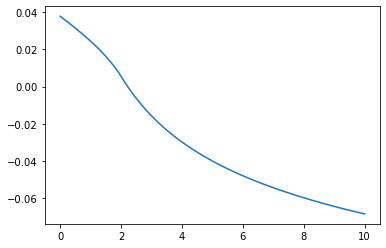

In [3]:
plt.plot(y_grid, ϕ)

**ODE for z**:
$$
0 = \min_h -\delta \eta \log z_2 + \frac{\xi_m}{2}h^\prime h + \frac{d\psi(z_2)}{d z_2}\left[-\rho(z_2-\mu_2) + \sqrt{z_2}\sigma_2 \cdot h\right] + \frac{1}{2}\frac{d^2 \psi(z_2)}{(d z_2)^2}z_2|\sigma_2|^2
$$

The FOC of $h$ gives:
$$
h^* = -\frac{\frac{d\psi(z_2)}{d z_2}\sqrt{z_2}\sigma_2}{\xi_m}
$$

In [4]:
# Model parameters
η = .032
δ = .01

ρ = 0.9
μ_2 = 1.
σ_2 = 0.013145579 / np.sqrt(1.86/1000)

ξ_m = 1000.

n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

model_paras = (η, δ, ρ, μ_2, σ_2, ξ_m) 
ψ = ode_z(z_grid, model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=2_000)

Iteration 1: LHS Error: 0.00040479137003108286; RHS Error 0.0006374361746997154
Iteration 2: LHS Error: 0.00026183650263205327; RHS Error 0.00040480145564217816
Iteration 3: LHS Error: 0.00017258443822324582; RHS Error 0.00026184550119110275
Iteration 4: LHS Error: 0.00011600660034984198; RHS Error 0.000172584109967781
Iteration 5: LHS Error: 7.963645101756217e-05; RHS Error 0.00011600595844048366
Iteration 6: LHS Error: 5.597047382177155e-05; RHS Error 7.964974683015143e-05
Iteration 7: LHS Error: 4.0417620415354565e-05; RHS Error 5.599730893678158e-05
Iteration 8: LHS Error: 3.0072261897231677e-05; RHS Error 4.041970921780008e-05
Iteration 9: LHS Error: 2.3155562249276397e-05; RHS Error 3.0084565463339366e-05
Iteration 10: LHS Error: 1.8503193585263063e-05; RHS Error 2.317477985590489e-05
Iteration 11: LHS Error: 1.534760539430454e-05; RHS Error 1.8511672984357748e-05
Iteration 12: LHS Error: 1.321041828348168e-05; RHS Error 1.536400502906283e-05
Iteration 13: LHS Error: 1.1742003632

Iteration 105: LHS Error: 8.561127829918988e-06; RHS Error 8.56430609075449e-06
Iteration 106: LHS Error: 8.561342103422659e-06; RHS Error 8.565188943672865e-06
Iteration 107: LHS Error: 8.561232414269228e-06; RHS Error 8.567777391666734e-06
Iteration 108: LHS Error: 8.56099238640657e-06; RHS Error 8.567809215290765e-06
Iteration 109: LHS Error: 8.572517270559433e-06; RHS Error 8.567772495076656e-06
Iteration 110: LHS Error: 8.562544358584024e-06; RHS Error 8.56280191370115e-06
Iteration 111: LHS Error: 8.56497828413257e-06; RHS Error 8.562178125750658e-06
Iteration 112: LHS Error: 8.56238544816708e-06; RHS Error 8.561817849336057e-06
Iteration 113: LHS Error: 8.56305290116967e-06; RHS Error 8.561930660007085e-06
Iteration 114: LHS Error: 8.561983285318648e-06; RHS Error 8.562124735571109e-06
Iteration 115: LHS Error: 8.563708114506545e-06; RHS Error 8.562220323594405e-06
Iteration 116: LHS Error: 8.561816297207104e-06; RHS Error 8.562492493288728e-06
Iteration 117: LHS Error: 8.561396

Iteration 208: LHS Error: 8.564196977081135e-06; RHS Error 8.561479806809343e-06
Iteration 209: LHS Error: 8.56468346589884e-06; RHS Error 8.56272603600885e-06
Iteration 210: LHS Error: 8.561775410375803e-06; RHS Error 8.563035728297619e-06
Iteration 211: LHS Error: 8.563973376571815e-06; RHS Error 8.5617148216726e-06
Iteration 212: LHS Error: 8.561633111276107e-06; RHS Error 8.561819058285647e-06
Iteration 213: LHS Error: 8.56160410213293e-06; RHS Error 8.56314509051803e-06
Iteration 214: LHS Error: 8.572627181142048e-06; RHS Error 8.571018937139803e-06
Iteration 215: LHS Error: 8.567045128640707e-06; RHS Error 8.56197150847084e-06
Iteration 216: LHS Error: 8.565259157423952e-06; RHS Error 8.56267477673021e-06
Iteration 217: LHS Error: 8.56183098554516e-06; RHS Error 8.562826912033283e-06
Iteration 218: LHS Error: 8.56115860907588e-06; RHS Error 8.561934812570622e-06
Iteration 219: LHS Error: 8.562775437171224e-06; RHS Error 8.561952087038923e-06
Iteration 220: LHS Error: 8.5613309045

Iteration 324: LHS Error: 8.569602675507961e-06; RHS Error 8.618183385844709e-06
Iteration 325: LHS Error: 8.5624408331271e-06; RHS Error 8.639051283090631e-06
Iteration 326: LHS Error: 8.568643807607516e-06; RHS Error 8.635004149161864e-06
Iteration 327: LHS Error: 8.567656368386415e-06; RHS Error 8.610841483550904e-06
Iteration 328: LHS Error: 8.568011947705659e-06; RHS Error 8.597561228546437e-06
Iteration 329: LHS Error: 8.56609963581197e-06; RHS Error 8.62014827786924e-06
Iteration 330: LHS Error: 8.5752541062762e-06; RHS Error 8.604301434356047e-06
Iteration 331: LHS Error: 8.564742585784497e-06; RHS Error 8.636465464713827e-06
Iteration 332: LHS Error: 8.561701129924763e-06; RHS Error 8.631157420436976e-06
Iteration 333: LHS Error: 8.561243194630912e-06; RHS Error 8.626714471164545e-06
Iteration 334: LHS Error: 8.56608638037876e-06; RHS Error 8.625509654778998e-06
Iteration 335: LHS Error: 8.571502030663104e-06; RHS Error 8.611463871417626e-06
Iteration 336: LHS Error: 8.5648598

Iteration 443: LHS Error: 8.580074840929246e-06; RHS Error 8.648814737534588e-06
Iteration 444: LHS Error: 8.56868685590378e-06; RHS Error 8.6662180346981e-06
Iteration 445: LHS Error: 8.565685125021694e-06; RHS Error 8.64111414300672e-06
Iteration 446: LHS Error: 8.592328368122164e-06; RHS Error 8.651055783268449e-06
Iteration 447: LHS Error: 8.594002337553985e-06; RHS Error 8.586897908389503e-06
Iteration 448: LHS Error: 8.580618610479901e-06; RHS Error 8.660589609672028e-06
Iteration 449: LHS Error: 8.563128923646125e-06; RHS Error 8.622350999097693e-06
Iteration 450: LHS Error: 8.588225913008698e-06; RHS Error 8.627902632952252e-06
Iteration 451: LHS Error: 8.566500378766849e-06; RHS Error 8.666552524350547e-06
Iteration 452: LHS Error: 8.571537406350076e-06; RHS Error 8.641753167655563e-06
Iteration 453: LHS Error: 8.588743733199504e-06; RHS Error 8.633019534545609e-06
Iteration 454: LHS Error: 8.565246878097267e-06; RHS Error 8.671109558227642e-06
Iteration 455: LHS Error: 8.5708

Iteration 566: LHS Error: 8.575803454195785e-06; RHS Error 8.648346192833287e-06
Iteration 567: LHS Error: 8.571987920809581e-06; RHS Error 8.662065305889812e-06
Iteration 568: LHS Error: 8.577881371328415e-06; RHS Error 8.702484567713238e-06
Iteration 569: LHS Error: 8.574512346952098e-06; RHS Error 8.649891357808694e-06
Iteration 570: LHS Error: 8.59364169412697e-06; RHS Error 8.635174891245584e-06
Iteration 571: LHS Error: 8.589814871545493e-06; RHS Error 8.679980135848449e-06
Iteration 572: LHS Error: 8.572496860131257e-06; RHS Error 8.705808041426107e-06
Iteration 573: LHS Error: 8.572516556600972e-06; RHS Error 8.704724275241673e-06
Iteration 574: LHS Error: 8.6070259532698e-06; RHS Error 8.709073767013522e-06
Iteration 575: LHS Error: 8.578000526538853e-06; RHS Error 8.641805554539673e-06
Iteration 576: LHS Error: 8.571605719783111e-06; RHS Error 8.675363414423968e-06
Iteration 577: LHS Error: 8.59182748194241e-06; RHS Error 8.665026537823086e-06
Iteration 578: LHS Error: 8.5699

Iteration 689: LHS Error: 8.632815969312688e-06; RHS Error 8.700559201417588e-06
Iteration 690: LHS Error: 8.597668059081957e-06; RHS Error 8.61375275670916e-06
Iteration 691: LHS Error: 8.582279344925697e-06; RHS Error 8.678737628225346e-06
Iteration 692: LHS Error: 8.587682174940672e-06; RHS Error 8.70204093010059e-06
Iteration 693: LHS Error: 8.582325361987386e-06; RHS Error 8.655497375097425e-06
Iteration 694: LHS Error: 8.570513497813993e-06; RHS Error 8.68791249603848e-06
Iteration 695: LHS Error: 8.588439837564285e-06; RHS Error 8.690501859981198e-06
Iteration 696: LHS Error: 8.56855320500137e-06; RHS Error 8.719782699687366e-06
Iteration 697: LHS Error: 8.576482528156043e-06; RHS Error 8.698362398818925e-06
Iteration 698: LHS Error: 8.583313841753308e-06; RHS Error 8.717423422919981e-06
Iteration 699: LHS Error: 8.645200362788694e-06; RHS Error 8.733454595369512e-06
Iteration 700: LHS Error: 8.597473828067005e-06; RHS Error 8.629489585632196e-06
Iteration 701: LHS Error: 8.5808

Iteration 811: LHS Error: 8.56952116490197e-06; RHS Error 8.702250701797401e-06
Iteration 812: LHS Error: 8.593513478066805e-06; RHS Error 8.679325727761593e-06
Iteration 813: LHS Error: 8.588467280670233e-06; RHS Error 8.708609997450567e-06
Iteration 814: LHS Error: 8.585527655811595e-06; RHS Error 8.657635125659553e-06
Iteration 815: LHS Error: 8.570533460517359e-06; RHS Error 8.6962531503525e-06
Iteration 816: LHS Error: 8.572014395085044e-06; RHS Error 8.678117495818116e-06
Iteration 817: LHS Error: 8.628556663185273e-06; RHS Error 8.671898387849761e-06
Iteration 818: LHS Error: 8.603942423499739e-06; RHS Error 8.637547580710625e-06
Iteration 819: LHS Error: 8.626434105349183e-06; RHS Error 8.664144236874584e-06
Iteration 820: LHS Error: 8.621461290429788e-06; RHS Error 8.71844809556641e-06
Iteration 821: LHS Error: 8.562717106663266e-06; RHS Error 8.632502815196443e-06
Iteration 822: LHS Error: 8.617737334327101e-06; RHS Error 8.635543879073236e-06
Iteration 823: LHS Error: 8.5829

Iteration 915: LHS Error: 8.588033271651405e-06; RHS Error 8.701813901102666e-06
Iteration 916: LHS Error: 8.567482740527363e-06; RHS Error 8.72661704021696e-06
Iteration 917: LHS Error: 8.620656887798478e-06; RHS Error 8.720898808416784e-06
Iteration 918: LHS Error: 8.570051985288749e-06; RHS Error 8.652999897134435e-06
Iteration 919: LHS Error: 8.565983748969747e-06; RHS Error 8.67687179135514e-06
Iteration 920: LHS Error: 8.591862463243685e-06; RHS Error 8.66972863379663e-06
Iteration 921: LHS Error: 8.58213236994837e-06; RHS Error 8.705389908917455e-06
Iteration 922: LHS Error: 8.566830818348796e-06; RHS Error 8.720723321997497e-06
Iteration 923: LHS Error: 8.585510967723184e-06; RHS Error 8.703210211678239e-06
Iteration 924: LHS Error: 8.590485979574451e-06; RHS Error 8.68298300743753e-06
Iteration 925: LHS Error: 8.656500844692223e-06; RHS Error 8.71422969330978e-06
Iteration 926: LHS Error: 8.619953077654632e-06; RHS Error 8.612046615960839e-06
Iteration 927: LHS Error: 8.585749

Iteration 1035: LHS Error: 8.569243840863237e-06; RHS Error 8.696468594217993e-06
Iteration 1036: LHS Error: 8.562407514869225e-06; RHS Error 8.690635301678126e-06
Iteration 1037: LHS Error: 8.602798671287007e-06; RHS Error 8.688872344875449e-06
Iteration 1038: LHS Error: 8.571624944025968e-06; RHS Error 8.737604814924795e-06
Iteration 1039: LHS Error: 8.596810909119838e-06; RHS Error 8.706851245475944e-06
Iteration 1040: LHS Error: 8.562216157629275e-06; RHS Error 8.742289707137842e-06
Iteration 1041: LHS Error: 8.57804309443988e-06; RHS Error 8.740455812180834e-06
Iteration 1042: LHS Error: 8.597010679636807e-06; RHS Error 8.714116055555084e-06
Iteration 1043: LHS Error: 8.629818027768368e-06; RHS Error 8.762784138654448e-06
Iteration 1044: LHS Error: 8.566335324873553e-06; RHS Error 8.678231618344649e-06
Iteration 1045: LHS Error: 8.646399651372066e-06; RHS Error 8.689960940613253e-06
Iteration 1046: LHS Error: 8.642389549203336e-06; RHS Error 8.61230222113003e-06
Iteration 1047: LH

Iteration 1156: LHS Error: 8.62111843149757e-06; RHS Error 8.705914297333934e-06
Iteration 1157: LHS Error: 8.592815913067986e-06; RHS Error 8.751824519110686e-06
Iteration 1158: LHS Error: 8.562012687136217e-06; RHS Error 8.761285221201075e-06
Iteration 1159: LHS Error: 8.566981789529665e-06; RHS Error 8.768877417720926e-06
Iteration 1160: LHS Error: 8.607621427883863e-06; RHS Error 8.754592889893733e-06
Iteration 1161: LHS Error: 8.620485210797738e-06; RHS Error 8.716854051104878e-06
Iteration 1162: LHS Error: 8.592343842593261e-06; RHS Error 8.772382485441963e-06
Iteration 1163: LHS Error: 8.602971861979697e-06; RHS Error 8.786819488087029e-06
Iteration 1164: LHS Error: 8.569686473050217e-06; RHS Error 8.740563306136682e-06
Iteration 1165: LHS Error: 8.603943758076285e-06; RHS Error 8.739920284541944e-06
Iteration 1166: LHS Error: 8.652090136593987e-06; RHS Error 8.781589028318223e-06
Iteration 1167: LHS Error: 8.593214791756745e-06; RHS Error 8.698165610137004e-06
Iteration 1168: L

Iteration 1278: LHS Error: 8.56785834910459e-06; RHS Error 8.69962012380168e-06
Iteration 1279: LHS Error: 8.571814572916683e-06; RHS Error 8.701272532378674e-06
Iteration 1280: LHS Error: 8.66496453221996e-06; RHS Error 8.717484996023748e-06
Iteration 1281: LHS Error: 8.58599181151505e-06; RHS Error 8.61131121653204e-06
Iteration 1282: LHS Error: 8.596346511241179e-06; RHS Error 8.608609143468803e-06
Iteration 1283: LHS Error: 8.59801235201206e-06; RHS Error 8.662474675909357e-06
Iteration 1284: LHS Error: 8.628893859875114e-06; RHS Error 8.681892451528606e-06
Iteration 1285: LHS Error: 8.570256715613456e-06; RHS Error 8.729202355048425e-06
Iteration 1286: LHS Error: 8.585440135173289e-06; RHS Error 8.707558690288473e-06
Iteration 1287: LHS Error: 8.692770115921802e-06; RHS Error 8.686188228662032e-06
Iteration 1288: LHS Error: 8.616137106393432e-06; RHS Error 8.604227393812087e-06
Iteration 1289: LHS Error: 8.649589053437434e-06; RHS Error 8.651480284286445e-06
Iteration 1290: LHS Er

Iteration 1399: LHS Error: 8.57857281269872e-06; RHS Error 8.699414871652365e-06
Iteration 1400: LHS Error: 8.564405845755407e-06; RHS Error 8.725520019851787e-06
Iteration 1401: LHS Error: 8.60006968088703e-06; RHS Error 8.74105919386898e-06
Iteration 1402: LHS Error: 8.59144572416641e-06; RHS Error 8.684434080714854e-06
Iteration 1403: LHS Error: 8.659516268190795e-06; RHS Error 8.729762588311038e-06
Iteration 1404: LHS Error: 8.69894516052419e-06; RHS Error 8.638402679241237e-06
Iteration 1405: LHS Error: 8.612740547293482e-06; RHS Error 8.657282785376599e-06
Iteration 1406: LHS Error: 8.641470294064313e-06; RHS Error 8.617525019941031e-06
Iteration 1407: LHS Error: 8.644247784361098e-06; RHS Error 8.647103597593368e-06
Iteration 1408: LHS Error: 8.639434635623888e-06; RHS Error 8.65520916672847e-06
Iteration 1409: LHS Error: 8.63414599124035e-06; RHS Error 8.677495231565187e-06
Iteration 1410: LHS Error: 8.592178348630977e-06; RHS Error 8.712786459861449e-06
Iteration 1411: LHS Err

Iteration 1525: LHS Error: 8.654513616059706e-06; RHS Error 8.786956573792284e-06
Iteration 1526: LHS Error: 8.577479893499135e-06; RHS Error 8.698825962638146e-06
Iteration 1527: LHS Error: 8.623949882401172e-06; RHS Error 8.723518938231394e-06
Iteration 1528: LHS Error: 8.723795058293918e-06; RHS Error 8.775510392377054e-06
Iteration 1529: LHS Error: 8.604134772797686e-06; RHS Error 8.657550643010974e-06
Iteration 1530: LHS Error: 8.692809312180888e-06; RHS Error 8.691266201627543e-06
Iteration 1531: LHS Error: 8.609006404305605e-06; RHS Error 8.614617125805667e-06
Iteration 1532: LHS Error: 8.606108994221179e-06; RHS Error 8.58675554001227e-06
Iteration 1533: LHS Error: 8.649107611103518e-06; RHS Error 8.688540973589352e-06
Iteration 1534: LHS Error: 8.63498832709246e-06; RHS Error 8.763014529391698e-06
Iteration 1535: LHS Error: 8.598345896020446e-06; RHS Error 8.68299411862128e-06
Iteration 1536: LHS Error: 8.572326468248362e-06; RHS Error 8.671719478520732e-06
Iteration 1537: LHS

Iteration 1648: LHS Error: 8.685471231343472e-06; RHS Error 8.62416056160312e-06
Iteration 1649: LHS Error: 8.577062477392247e-06; RHS Error 8.674103135093475e-06
Iteration 1650: LHS Error: 8.701246228893025e-06; RHS Error 8.657360770880044e-06
Iteration 1651: LHS Error: 8.626517807195852e-06; RHS Error 8.637746849011324e-06
Iteration 1652: LHS Error: 8.692668286416905e-06; RHS Error 8.575695810194922e-06
Iteration 1653: LHS Error: 8.642678874919499e-06; RHS Error 8.741074082499456e-06
Iteration 1654: LHS Error: 8.602282001333658e-06; RHS Error 8.558063298534364e-06
Iteration 1655: LHS Error: 8.602621702892208e-06; RHS Error 8.65845669305044e-06
Iteration 1656: LHS Error: 8.571737596232976e-06; RHS Error 8.762265036613745e-06
Iteration 1657: LHS Error: 8.789794342033488e-06; RHS Error 8.764951865824686e-06
Iteration 1658: LHS Error: 8.687976745868492e-06; RHS Error 8.594441349175311e-06
Iteration 1659: LHS Error: 8.611601371425262e-06; RHS Error 8.684476642939433e-06
Iteration 1660: LH

Iteration 1775: LHS Error: 8.596515180158554e-06; RHS Error 8.652258159267995e-06
Iteration 1776: LHS Error: 8.727538951482441e-06; RHS Error 8.616188063461044e-06
Iteration 1777: LHS Error: 8.770856400273572e-06; RHS Error 8.671087234716655e-06
Iteration 1778: LHS Error: 8.744866398045087e-06; RHS Error 8.652539037035491e-06
Iteration 1779: LHS Error: 8.633209997620933e-06; RHS Error 8.637350676056531e-06
Iteration 1780: LHS Error: 8.591245485259358e-06; RHS Error 8.590277076537438e-06
Iteration 1781: LHS Error: 8.5721972167066e-06; RHS Error 8.6644181180162e-06
Iteration 1782: LHS Error: 8.685696698033929e-06; RHS Error 8.673875343002567e-06
Iteration 1783: LHS Error: 8.647448595414803e-06; RHS Error 8.777324368868043e-06
Iteration 1784: LHS Error: 8.637385333369954e-06; RHS Error 8.555747229030426e-06
Iteration 1785: LHS Error: 8.64283794282765e-06; RHS Error 8.625397076679811e-06
Iteration 1786: LHS Error: 8.7363697893212e-06; RHS Error 8.772355601878066e-06
Iteration 1787: LHS Err

Iteration 1901: LHS Error: 8.67847171776015e-06; RHS Error 8.656151391138185e-06
Iteration 1902: LHS Error: 8.603527945783701e-06; RHS Error 8.789125430704763e-06
Iteration 1903: LHS Error: 8.603857308775442e-06; RHS Error 8.751496895637414e-06
Iteration 1904: LHS Error: 8.574157893296436e-06; RHS Error 8.720854895562745e-06
Iteration 1905: LHS Error: 8.81724136712024e-06; RHS Error 8.744977575874454e-06
Iteration 1906: LHS Error: 8.655115912095668e-06; RHS Error 8.67102264451346e-06
Iteration 1907: LHS Error: 8.69175915693167e-06; RHS Error 8.63285920482855e-06
Iteration 1908: LHS Error: 8.773335072270391e-06; RHS Error 8.76583681877198e-06
Iteration 1909: LHS Error: 8.66572407318307e-06; RHS Error 8.590652000137742e-06
Iteration 1910: LHS Error: 8.575935424777817e-06; RHS Error 8.660164063988484e-06
Iteration 1911: LHS Error: 8.673966526488025e-06; RHS Error 8.718857431893397e-06
Iteration 1912: LHS Error: 8.747778938722472e-06; RHS Error 8.805594645318467e-06
Iteration 1913: LHS Err

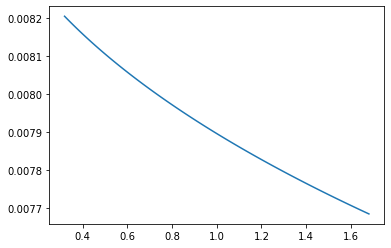

In [5]:
plt.plot(z_grid, ψ)